## Predicting phonon DoS
### Deep Learning on Graph Neural Neworks

In [2]:
!git clone https://github.com/ninarina12/phononDoS_tutorial.git
%cd phononDoS_tutorial

Cloning into 'phononDoS_tutorial'...
remote: Enumerating objects: 312, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 312 (delta 7), reused 12 (delta 4), pack-reused 294 (from 1)
Receiving objects: 100% (312/312), 83.18 MiB | 1.39 MiB/s, done.
Resolving deltas: 100% (160/160), done.
/home/angelica/Documents/Angelica/Rpi/Semesters/Fall2024/DL/Predicting-phonon-DoS/phononDoS_tutorial


In [3]:
!pip install ase e3nn
!pip install torch-scatter torch-cluster torch-sparse torch-spline-conv -f https://pytorch-geometric.com/whl/torch-$(python -c "import torch; print(torch.__version__)").html
!pip install torch-geometric
!pip install pickleshare

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: dblatex 0.3.11py3 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of dblatex or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
DEPRECATION: dblatex 0.3.11py3 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of dblatex or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at htt

In [4]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter

# import e3nn
# from e3nn import o3

from typing import Dict, Union

# crystal structure data
from ase import Atom, Atoms
from ase.neighborlist import neighbor_list
from ase.visualize.plot import plot_atoms

# data pre-processing and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# utilities
import time
from tqdm import tqdm
from utils.utils_data import (load_data, train_valid_test_split, plot_example, plot_predictions, plot_partials,
                              palette, colors, cmap)
from utils.utils_model import Network, visualize_layers, train
from utils.utils_plot import plotly_surface, plot_orbitals, get_middle_feats

bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

### Data provenance
We train our model using the database of Density Functional Perturbation Theory (DFPT)-calculated phonon densities of states (DoS), containing approximately 1,500 crystalline solids [[Petretto et al. 2018]](https://doi.org/10.1038/sdata.2018.65).

In [5]:
# load data
df, species = load_data('data/data.csv')
df.head()

100%|██████████| 1522/1522 [00:00<00:00, 29291.36it/s]                          


,mp_id,structure,phfreq,phdos,pdos,formula,species
0,mp-1000,"(Atom('Ba', [0.0, 0.0, 0.0], index=0), Atom('T...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.0, 0.1603814665137704, 0.366293016390463, 0...","{'Ba': [0.0, 0.17004785173719497, 0.4321591874...",BaTe,"[Te, Ba]"
1,mp-1002124,"(Atom('Hf', [0.0, 0.0, 0.0], index=0), Atom('C...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.02337731725373556, 0.030910686260937723, 0....","{'Hf': [0.026541048236378005, 0.03587084551615...",CHf,"[Hf, C]"
2,mp-1002164,"(Atom('Ge', [0.0, 0.0, 0.0], index=0), Atom('C...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.0, 0.0017221473876927959, 0.005981246148731...","{'Ge': [0.0, 0.00316167053214679, 0.0109190651...",CGe,"[Ge, C]"
3,mp-10044,"(Atom('B', [4.440892098500626e-16, 6.194849927...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.0, 0.002277293012378372, 0.0078646582782471...","{'B': [0.0, 0.00029269193672558846, 0.00105324...",AsB,"[B, As]"
4,mp-1008223,"(Atom('Ca', [0.0, 0.0, 0.0], index=0), Atom('S...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.0, 0.258870972416879, 0.5505201512544314, 0...","{'Ca': [0.0, 0.11150000312651394, 0.2215562000...",CaSe,"[Ca, Se]"


### Data structures
Crystal structures are represented as [ASE](https://wiki.fysik.dtu.dk/ase/ase/atoms.html?highlight=atoms#the-atoms-object) (Atomic Simulation Environment) `Atoms` objects, which store the atomic species and positions of each atom in the unit cell, as well as the lattice vectors of the unit cell.

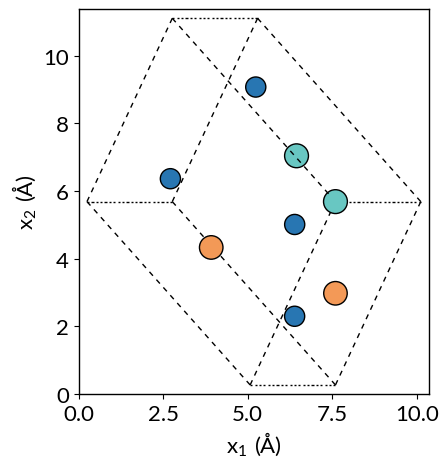

In [6]:
# plot an example structure
i = 12 # structure index in dataframe

struct = df.iloc[i]['structure']
symbols = np.unique(list(struct.symbols))
z = dict(zip(symbols, range(len(symbols))))

fig, ax = plt.subplots(figsize=(6,5))
norm = plt.Normalize(vmin=0, vmax=len(symbols)-1)
color = [mpl.colors.to_hex(k) for k in cmap(norm([z[j] for j in list(struct.symbols)]))]
plot_atoms(struct, ax, radii=0.25, colors=color, rotation=('0x,90y,0z'))

ax.set_xlabel(r'$x_1\ (\AA)$')
ax.set_ylabel(r'$x_2\ (\AA)$');

average lattice parameter (a/b/c): 4.913216585660792 / 5.258921900844212 / 6.5187904554067595


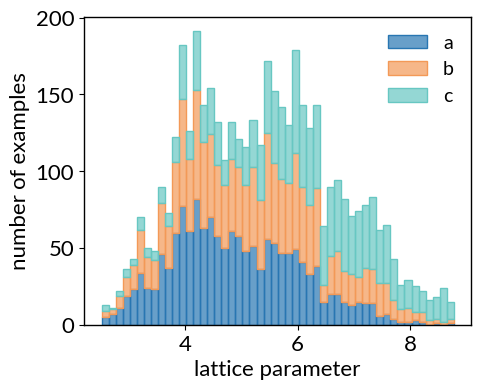

In [7]:
# lattice parameter statistics
def get_lattice_parameters(df):
    a = []
    for entry in df.itertuples():
        a.append(entry.structure.cell.cellpar()[:3])
    return np.stack(a)

a = get_lattice_parameters(df)

fig, ax = plt.subplots(1,1, figsize=(5,4))
b = 0.
bins = 50
for d, c, n in zip(['a', 'b', 'c'], colors.values(), [a[:,0], a[:,1], a[:,2]]):
    color = [int(c.lstrip('#')[i:i+2], 16)/255. for i in (0,2,4)]
    y, bins, _, = ax.hist(n, bins=bins, fc=color+[0.7], ec=color, bottom=b, label=d)
    b += y
ax.set_xlabel('lattice parameter')
ax.set_ylabel('number of examples')
ax.legend(frameon=False)

print('average lattice parameter (a/b/c):', a[:,0].mean(), '/', a[:,1].mean(), '/', a[:,2].mean())

### Feature representation
We construct the inputs to our neural network following the `e3nn` [Documentation](https://docs.e3nn.org/en/latest/guide/periodic_boundary_conditions.html) on handling point inputs with periodic boundary conditions. For a given crystal, each atom in the unit cell is associated with a feature vector that one-hot encodes its atomic mass in the index corresponding to its atomic number. The unit cell of the crystal is encoded as a graph in which two atoms (nodes) are joined by an edge if they are within a cutoff radius `r_max` of one another.

In [8]:
# one-hot encoding atom type and mass
type_encoding = {}
specie_am = []
for Z in tqdm(range(1, 119), bar_format=bar_format):
    specie = Atom(Z)
    type_encoding[specie.symbol] = Z - 1
    specie_am.append(specie.mass)

type_onehot = torch.eye(len(type_encoding))
am_onehot = torch.diag(torch.tensor(specie_am))

100%|██████████| 118/118 [00:00<00:00, 83181.15it/s]                            


In [9]:
# build data
def build_data(entry, type_encoding, type_onehot, r_max=5.):
    symbols = list(entry.structure.symbols).copy()
    positions = torch.from_numpy(entry.structure.positions.copy())
    lattice = torch.from_numpy(entry.structure.cell.array.copy()).unsqueeze(0)

    # edge_src and edge_dst are the indices of the central and neighboring atom, respectively
    # edge_shift indicates whether the neighbors are in different images or copies of the unit cell
    edge_src, edge_dst, edge_shift = neighbor_list("ijS", a=entry.structure, cutoff=r_max, self_interaction=True)
    
    # compute the relative distances and unit cell shifts from periodic boundaries
    edge_batch = positions.new_zeros(positions.shape[0], dtype=torch.long)[torch.from_numpy(edge_src)]
    edge_vec = (positions[torch.from_numpy(edge_dst)]
                - positions[torch.from_numpy(edge_src)]
                + torch.einsum('ni,nij->nj', torch.tensor(edge_shift, dtype=default_dtype), lattice[edge_batch]))

    # compute edge lengths (rounded only for plotting purposes)
    edge_len = np.around(edge_vec.norm(dim=1).numpy(), decimals=2)
    
    data = tg.data.Data(
        pos=positions, lattice=lattice, symbol=symbols,
        x=am_onehot[[type_encoding[specie] for specie in symbols]],   # atomic mass (node feature)
        z=type_onehot[[type_encoding[specie] for specie in symbols]], # atom type (node attribute)
        edge_index=torch.stack([torch.LongTensor(edge_src), torch.LongTensor(edge_dst)], dim=0),
        edge_shift=torch.tensor(edge_shift, dtype=default_dtype),
        edge_vec=edge_vec, edge_len=edge_len,
        phdos=torch.from_numpy(entry.phdos).unsqueeze(0)
    )
    
    return data

r_max = 4. # cutoff radius
df['data'] = df.progress_apply(lambda x: build_data(x, type_encoding, type_onehot, r_max), axis=1)

100%|██████████| 1522/1522 [00:21<00:00, 71.57it/s]                             


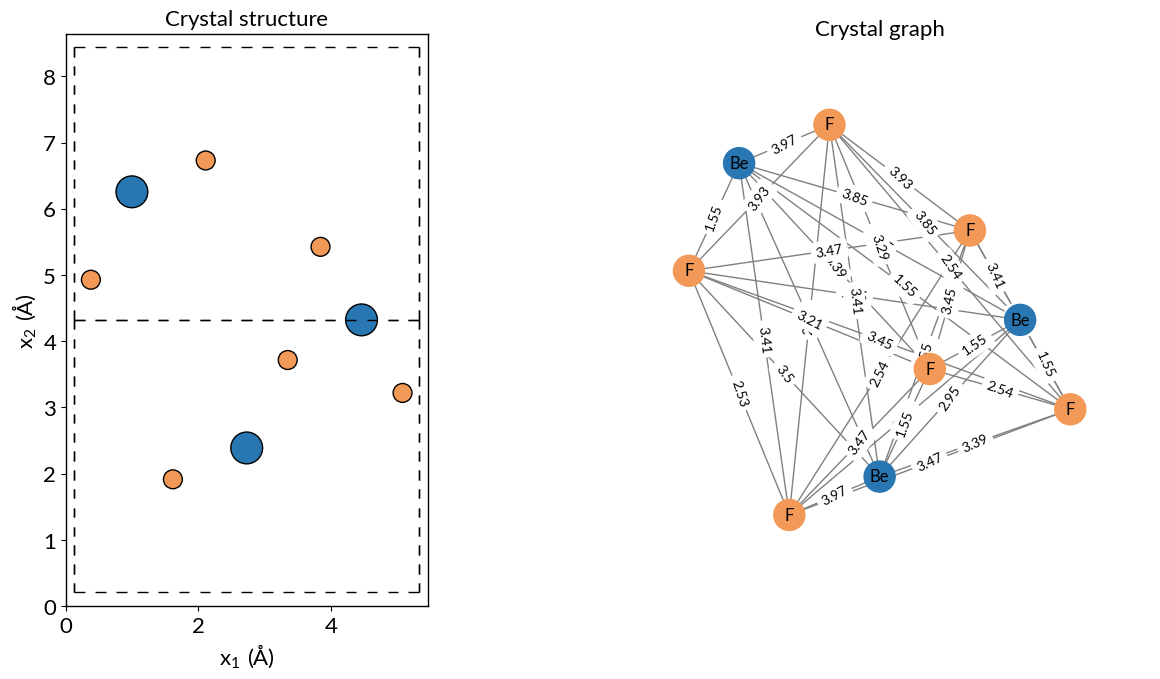

In [10]:
i = 244 # structure index in dataframe
plot_example(df, i=i, label_edges=True)

### Training, validation, and testing datasets
Split the data into training, validation, and testing datasets with balanced representation of different elements in each set.

split train/dev ...


100%|██████████| 64/64 [00:00<00:00, 254.43it/s]                                


split valid/test ...


100%|██████████| 62/62 [00:00<00:00, 256.05it/s]                                


number of training examples: 1192
number of validation examples: 141
number of testing examples: 189
total number of examples: 1522


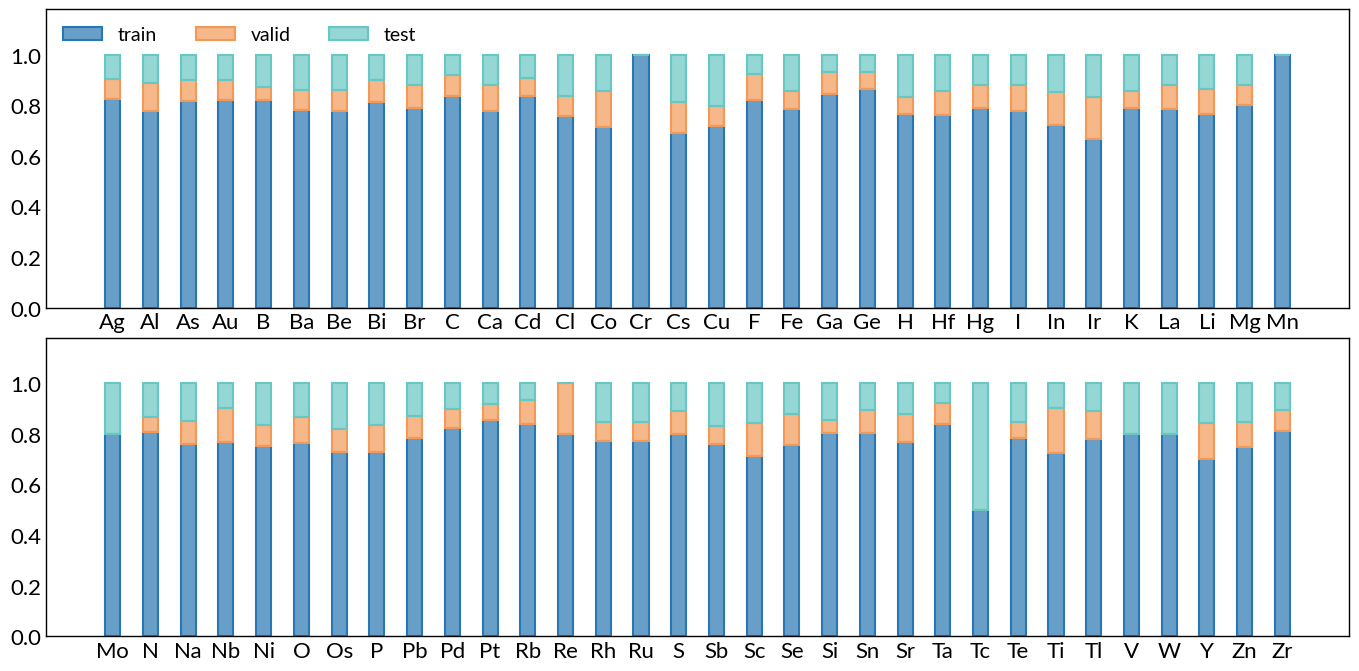

In [11]:
# train/valid/test split
idx_train, idx_valid, idx_test = train_valid_test_split(df, species, valid_size=.1, test_size=.1, seed=12, plot=True)

For use with the trained model provided, the indices of the training, validation, and test sets are loaded below. These indices were generated with a specific seed using the above `train_valid_test_split` function.

In [12]:
# load train/valid/test indices
with open('data/idx_train.txt', 'r') as f: idx_train = [int(i.split('\n')[0]) for i in f.readlines()]
with open('data/idx_valid.txt', 'r') as f: idx_valid = [int(i.split('\n')[0]) for i in f.readlines()]
with open('data/idx_test.txt', 'r') as f: idx_test = [int(i.split('\n')[0]) for i in f.readlines()]

# format dataloaders
batch_size = 1
dataloader_train = tg.loader.DataLoader(df.iloc[idx_train]['data'].values, batch_size=batch_size, shuffle=True)
dataloader_valid = tg.loader.DataLoader(df.iloc[idx_valid]['data'].values, batch_size=batch_size)
dataloader_test = tg.loader.DataLoader(df.iloc[idx_test]['data'].values, batch_size=batch_size)

average number of neighbors (train/valid/test): 15.837087001257574 / 15.272818455366098 / 15.455339153794492


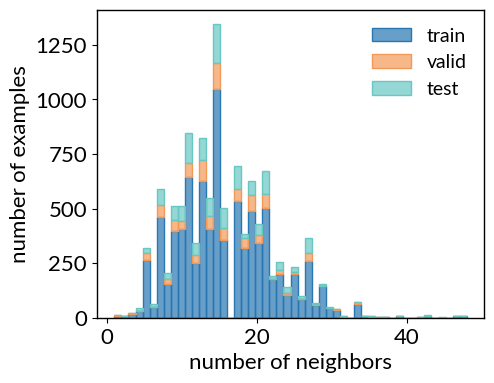

In [13]:
# calculate average number of neighbors
def get_neighbors(df, idx):
    n = []
    for entry in df.iloc[idx].itertuples():
        N = entry.data.pos.shape[0]
        for i in range(N):
            n.append(len((entry.data.edge_index[0] == i).nonzero()))
    return np.array(n)

n_train = get_neighbors(df, idx_train)
n_valid = get_neighbors(df, idx_valid)
n_test = get_neighbors(df, idx_test)

fig, ax = plt.subplots(1,1, figsize=(5,4))
b = 0.
bins = 50
for (d, c), n in zip(colors.items(), [n_train, n_valid, n_test]):
    color = [int(c.lstrip('#')[i:i+2], 16)/255. for i in (0,2,4)]
    y, bins, _, = ax.hist(n, bins=bins, fc=color+[0.7], ec=color, bottom=b, label=d)
    b += y
ax.set_xlabel('number of neighbors')
ax.set_ylabel('number of examples')
ax.legend(frameon=False)

print('average number of neighbors (train/valid/test):', n_train.mean(), '/', n_valid.mean(), '/', n_test.mean())

# Model

In [52]:
from torch_geometric.nn import MessagePassing
from torch_scatter import scatter


bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'


fontsize = 16
textsize = 14
sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
plt.rcParams['font.family'] = 'lato'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['font.size'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['legend.fontsize'] = textsize


class GNNConv(MessagePassing):
    def __init__(self, in_channels, out_channels, edge_dim):
        super().__init__(aggr='mean')  
        self.lin_node = torch.nn.Linear(in_channels, out_channels)
        self.lin_edge = torch.nn.Linear(edge_dim, out_channels)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * out_channels, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        )

    def forward(self, x, edge_index, edge_attr):
        x = self.lin_node(x)
        edge_attr = self.lin_edge(edge_attr)
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_i, x_j, edge_attr):
        # Construct messages
        tmp = torch.cat([x_j, edge_attr], dim=1)
        return self.mlp(tmp)
        
class Network(torch.nn.Module):
    def __init__(
        self,
        in_dim,
        em_dim,
        out_dim,
        layers,
        max_radius,
        number_of_basis=10,
        radial_layers=1,
        radial_neurons=100,
        num_neighbors=1.,
        num_nodes=1.,
        reduce_output=True,
    ) -> None:
        super().__init__()
        self.max_radius = max_radius
        self.number_of_basis = number_of_basis
        self.num_neighbors = num_neighbors
        self.num_nodes = num_nodes
        self.reduce_output = reduce_output

        # Input embedding
        self.em = torch.nn.Linear(in_dim, em_dim)
        
        # Edge embedding
        self.edge_embedding = torch.nn.Sequential(
            torch.nn.Linear(1, radial_neurons),
            torch.nn.ReLU(),
            *[torch.nn.Linear(radial_neurons, radial_neurons) for _ in range(radial_layers-1)],
            torch.nn.Linear(radial_neurons, number_of_basis)
        )

        # Network layers
        self.layers = torch.nn.ModuleList()
        for _ in range(layers):
            self.layers.append(GNNConv(em_dim, em_dim, number_of_basis))
        
        # Final layer
        self.final = torch.nn.Linear(em_dim, out_dim)

    def preprocess(self, data: Union[Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        if 'batch' in data:
            batch = data['batch']
        else:
            batch = data['pos'].new_zeros(data['pos'].shape[0], dtype=torch.long)

        if 'edge_index' in data:
            edge_src = data['edge_index'][0]
            edge_dst = data['edge_index'][1]
            edge_vec = data['edge_vec']
        else:
            edge_index = radius_graph(data['pos'], self.max_radius, batch)
            edge_src = edge_index[0]
            edge_dst = edge_index[1]
            edge_vec = data['pos'][edge_src] - data['pos'][edge_dst]

        return batch, edge_src, edge_dst, edge_vec

    def forward(self, data: Union[Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        batch, edge_src, edge_dst, edge_vec = self.preprocess(data)
        
        # Create edge features
        edge_length = edge_vec.norm(dim=1).unsqueeze(-1)
        edge_attr = self.edge_embedding(edge_length)
        
        # Get input features
        if 'x' in data:
            x = data['x']
        else:
            x = data['pos'].new_ones((data['pos'].shape[0], 1))
            
        # Initial embedding
        x = self.em(x)
        
        # Create edge_index tensor
        edge_index = torch.stack([edge_src, edge_dst])

        # Apply GNN layers
        for layer in self.layers:
            x = layer(x, edge_index, edge_attr)
            x = torch.relu(x)  # Activation after each layer

        # Final layer
        x = self.final(x)

        if self.reduce_output:
            return scatter(x, batch, dim=0).div(self.num_nodes**0.5)
        else:
            return x


def loglinspace(rate, step, end=None):
    t = 0
    while end is None or t <= end:
        yield t
        t = int(t + 1 + step*(1 - math.exp(-t*rate/step)))

        
def evaluate(model, dataloader, loss_fn, loss_fn_mae, device):
    model.eval()
    loss_cumulative = 0.
    loss_cumulative_mae = 0.
    start_time = time.time()
    with torch.no_grad():
        for j, d in enumerate(dataloader):
            d.to(device)
            output = model(d)
            loss = loss_fn(output, d.phdos).cpu()
            loss_mae = loss_fn_mae(output, d.phdos).cpu()
            loss_cumulative = loss_cumulative + loss.detach().item()
            loss_cumulative_mae = loss_cumulative_mae + loss_mae.detach().item()
    return loss_cumulative/len(dataloader), loss_cumulative_mae/len(dataloader)


def train(model, optimizer, dataloader_train, dataloader_valid, loss_fn, loss_fn_mae, run_name,
          max_iter=101, scheduler=None, device="cpu"):
    model.to(device)

    checkpoint_generator = loglinspace(0.3, 5)
    checkpoint = next(checkpoint_generator)
    start_time = time.time()


    try: model.load_state_dict(torch.load(run_name + '.torch')['state'])
    except:
        results = {}
        history = []
        s0 = 0
    else:
        results = torch.load(run_name + '.torch')
        history = results['history']
        s0 = history[-1]['step'] + 1


    for step in range(max_iter):
        model.train()
        loss_cumulative = 0.
        loss_cumulative_mae = 0.
        
        for j, d in tqdm(enumerate(dataloader_train), total=len(dataloader_train), bar_format=bar_format):
            d.to(device)
            output = model(d)
            loss = loss_fn(output, d.phdos).cpu()
            loss_mae = loss_fn_mae(output, d.phdos).cpu()
            loss_cumulative = loss_cumulative + loss.detach().item()
            loss_cumulative_mae = loss_cumulative_mae + loss_mae.detach().item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        end_time = time.time()
        wall = end_time - start_time

        if step == checkpoint:
            checkpoint = next(checkpoint_generator)
            assert checkpoint > step

            valid_avg_loss = evaluate(model, dataloader_valid, loss_fn, loss_fn_mae, device)
            train_avg_loss = evaluate(model, dataloader_train, loss_fn, loss_fn_mae, device)

            history.append({
                'step': s0 + step,
                'wall': wall,
                'batch': {
                    'loss': loss.item(),
                    'mean_abs': loss_mae.item(),
                },
                'valid': {
                    'loss': valid_avg_loss[0],
                    'mean_abs': valid_avg_loss[1],
                },
                'train': {
                    'loss': train_avg_loss[0],
                    'mean_abs': train_avg_loss[1],
                },
            })

            results = {
                'history': history,
                'state': model.state_dict()
            }

            print(f"Iteration {step+1:4d}   " +
                  f"train loss = {train_avg_loss[0]:8.4f}   " +
                  f"valid loss = {valid_avg_loss[0]:8.4f}   " +
                  f"elapsed time = {time.strftime('%H:%M:%S', time.gmtime(wall))}")

            with open(run_name + '.torch', 'wb') as f:
                torch.save(results, f)

        if scheduler is not None:
            scheduler.step()

### Network architecture

In [54]:
out_dim = len(df.iloc[0]['phfreq'])
em_dim = 64  

model = Network(
    in_dim=118,                            # dimension of one-hot encoding of atom type
    em_dim=em_dim,                         # dimension of atom-type embedding
    out_dim=out_dim,
    layers=2,                              # number of nonlinearities (number of convolutions = layers + 1)
    max_radius=r_max,                      # cutoff radius for convolution
    num_neighbors=n_train.mean(),          # scaling factor based on the typical number of neighbors
    reduce_output=True                     # whether or not to aggregate features of all atoms at the end
)

print(model)

Network(
  (em): Linear(in_features=118, out_features=64, bias=True)
  (edge_embedding): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
  (layers): ModuleList(
    (0-1): 2 x GNNConv()
  )
  (final): Linear(in_features=64, out_features=51, bias=True)
)


### Training
The model is trained using a mean-squared error loss function with an Adam optimizer.

In [55]:
opt = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.96)

# loss_fn = custom_loss
loss_fn = torch.nn.MSELoss()
loss_fn_mae = torch.nn.L1Loss()

In [56]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print('torch device:' , device)
run_name = 'model'

print(run_name)

torch device: cpu
model


In [57]:
model.pool = True
train(model, opt, dataloader_train, dataloader_valid, loss_fn, loss_fn_mae, run_name,
      max_iter=5, scheduler=scheduler, device=device)

100%|██████████| 1192/1192 [00:12<00:00, 93.26it/s]                             


Iteration    1   train loss =   0.0597   valid loss =   0.0579   elapsed time = 00:00:12


100%|██████████| 1192/1192 [00:22<00:00, 53.55it/s]                             


Iteration    2   train loss =   0.0585   valid loss =   0.0571   elapsed time = 00:00:43


100%|██████████| 1192/1192 [00:15<00:00, 76.25it/s]                             


Iteration    3   train loss =   0.0633   valid loss =   0.0612   elapsed time = 00:01:07


100%|██████████| 1192/1192 [00:15<00:00, 75.96it/s]                             


Iteration    4   train loss =   0.0589   valid loss =   0.0576   elapsed time = 00:01:28


100%|██████████| 1192/1192 [00:14<00:00, 82.35it/s]                             


Iteration    5   train loss =   0.0600   valid loss =   0.0588   elapsed time = 00:01:50


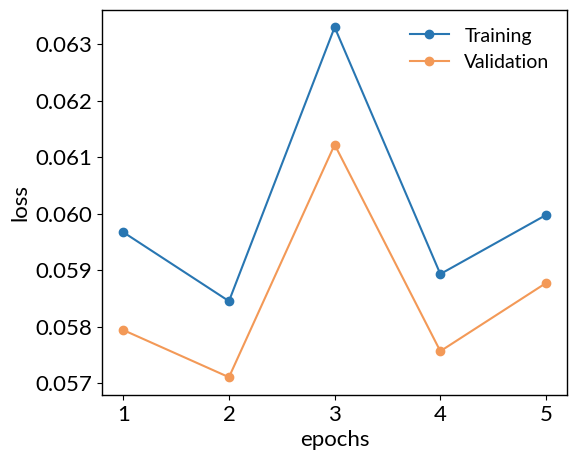

In [58]:
# load pre-trained model and plot its training history
run_name = 'model'

history = torch.load(run_name + '.torch', map_location=device)['history']
steps = [d['step'] + 1 for d in history]
loss_train = [d['train']['loss'] for d in history]
loss_valid = [d['valid']['loss'] for d in history]

fig, ax = plt.subplots(figsize=(6,5))
ax.plot(steps, loss_train, 'o-', label="Training", color=colors['train'])
ax.plot(steps, loss_valid, 'o-', label="Validation", color=colors['valid'])
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.legend(frameon=False);

### Results
We evaluate our model by visualizing the predicted and true DoS in each error quartile. We further compare the hidden features learned for each node to the partial DoS.

In [59]:
# predict on all data
model.load_state_dict(torch.load(run_name + '.torch', map_location=device)['state'])
model.pool = True

dataloader = tg.loader.DataLoader(df['data'].values, batch_size=64)
df['mse'] = 0.
df['phdos_pred'] = np.empty((len(df), 0)).tolist()

model.to(device)
model.eval()
with torch.no_grad():
    i0 = 0
    for i, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        output = model(d)
        loss = F.mse_loss(output, d.phdos, reduction='none').mean(dim=-1).cpu().numpy()
        df.loc[i0:i0 + len(d.phdos) - 1, 'phdos_pred'] = [[k] for k in output.cpu().numpy()]
        df.loc[i0:i0 + len(d.phdos) - 1, 'mse'] = loss
        i0 += len(d.phdos)
        
df['phdos_pred'] = df['phdos_pred'].map(lambda x: x[0])

100%|██████████| 24/24 [00:01<00:00, 22.90it/s]                                 


In [60]:
#plot_predictions(df, idx_train, 'Training')

In [61]:
#plot_predictions(df, idx_valid, 'Validation')

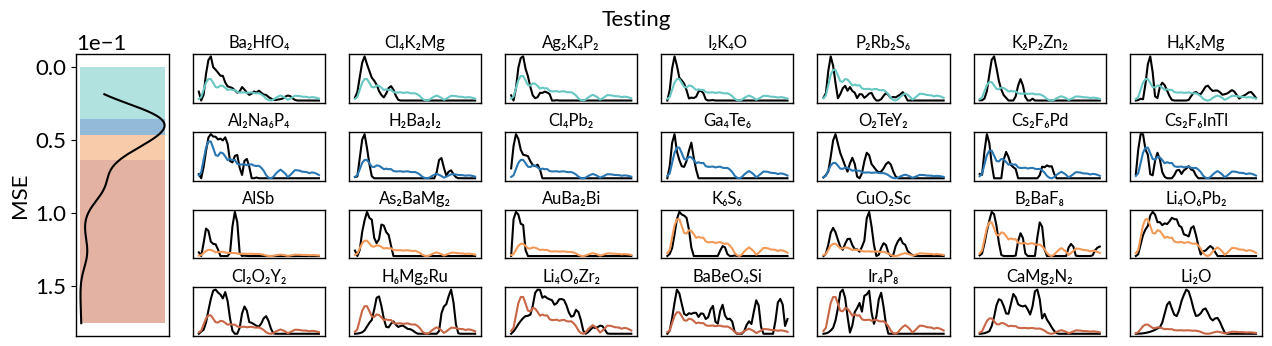

In [62]:
plot_predictions(df, idx_test, 'Testing')

/home/angelica/Documents/Angelica/Rpi/Semesters/Fall2024/DL/Predicting-phonon-DoS/phononDoS_tutorial/utils/utils_data.py:313: RuntimeWarning: invalid value encountered in divide
  ax[row,j+1].plot(entry.phfreq, pdos[s]/pdos[s].max(), color=palette[1], lw=2)


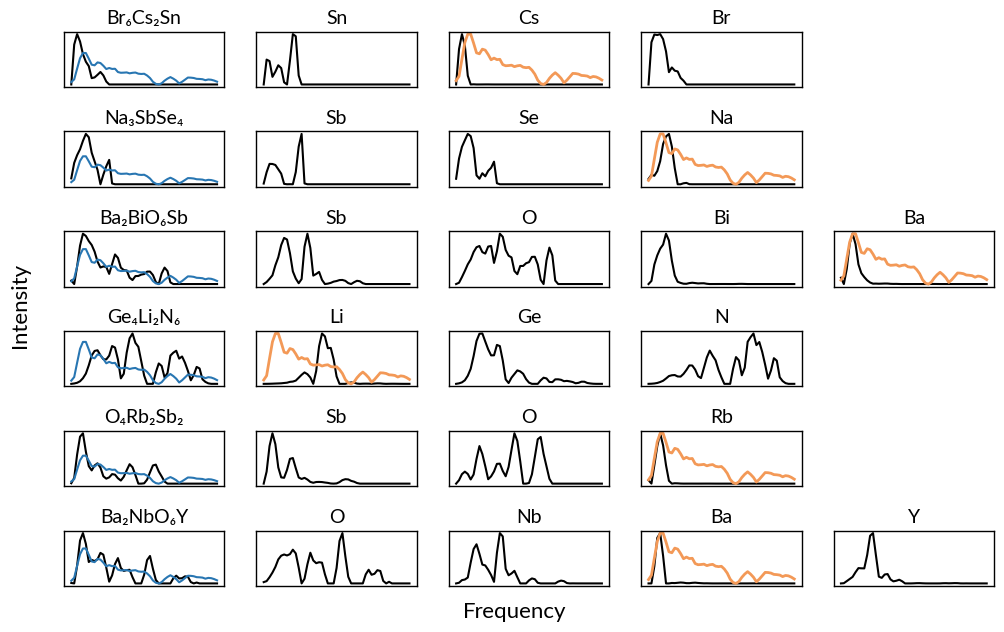

In [63]:
# compare to partial DoS
model.load_state_dict(torch.load(run_name + '.torch', map_location=device)['state'])
model.pool = False

# plot example predicted and true partial dos
plot_partials(model, df, idx_train, device=device)

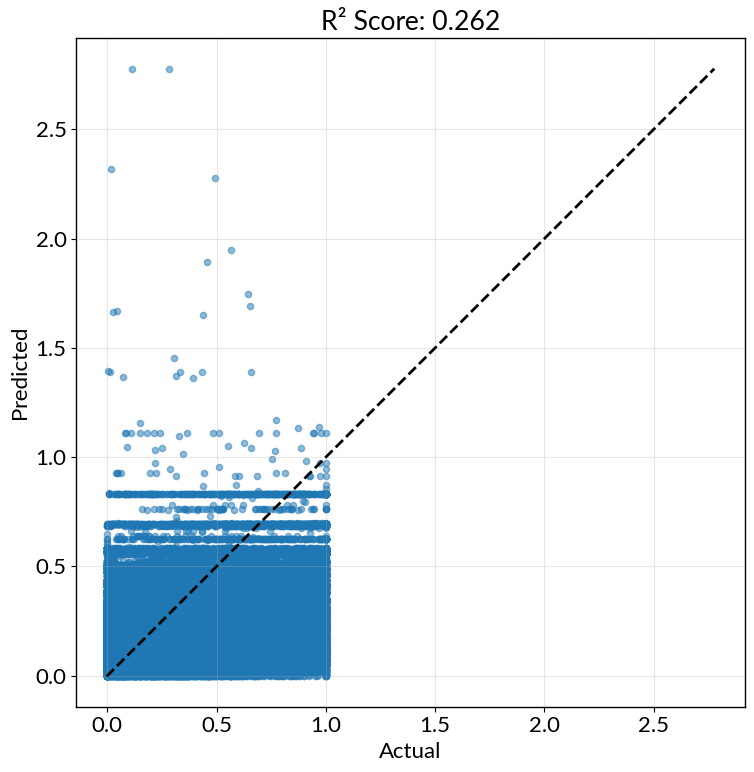

R² Score: 0.2621


In [64]:
from sklearn.metrics import r2_score

def plot_r2(df, true_col='phdos', pred_col='phdos_pred', figsize=(10, 8)):
    # Get flattened arrays
    y_true = np.concatenate(df[true_col].values)
    y_pred = np.concatenate(df[pred_col].values)
    
    # Calculate R2 score
    r2 = r2_score(y_true, y_pred)
    
    # Create figure
    plt.figure(figsize=figsize)
    
    plt.scatter(y_true, y_pred, 
               color='#1f77b4', 
               alpha=0.5,
               s=20)  
    
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val],
            'k--',  # black dashed line
            linewidth=2)
    
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'R² Score: {r2:.3f}')
    
    plt.grid(True, alpha=0.3)
    
    plt.axis('square')
    
    plt.tight_layout()
    plt.show()
    
    return r2

# Call the function
r2 = plot_r2(df)
print(f"R² Score: {r2:.4f}")